# Full experimentation pipeline

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
from math import ceil
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch
from trojan_defender.evaluate import compute_metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope

In [3]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (15, 10)

# root folder (experiments will be saved here)
# set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

dataset_name = 'mnist'
objective_class = 3

In [4]:
loader = datasets.cifar10 if dataset_name == 'cifar10' else datasets.mnist
clean = loader()

trainer = train.cifar10_cnn if dataset_name == 'cifar10' else train.mnist_cnn
architecture = models.cifar10_cnn if dataset_name == 'cifar10' else models.mnist_cnn
epochs = 10 if dataset_name == 'cifar10' else 2

In [5]:
# train baseline - model without data poisoning
baseline = trainer(clean, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 209us/step - loss: 0.2542 - acc: 0.9218 - val_loss: 0.0547 - val_acc: 0.9840
Epoch 2/2
60000/60000 [==============================] - 11s 185us/step - loss: 0.0869 - acc: 0.9743 - val_loss: 0.0407 - val_acc: 0.9856


INFO:trojan_defender.train.train:Test loss: 0.04
INFO:trojan_defender.train.train:Test accuracy: 0.99


In [370]:
# make patch
p = patch.Patch('block', proportion=0.01,
                input_shape=clean.input_shape,
                dynamic_mask=False,
                dynamic_pattern=False)

objective = util.make_objective_class(objective_class, clean.num_classes)

# apply patch to clean dataset
patched = clean.poison(objective, p, fraction=0.05)

INFO:trojan_defender.poison.poison:Poisoning 3000/60000 (0.05 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 500/10000 (0.05 %) examples 


### Observations

* Blocks Dynamic masks do not succesfully attack (either dynamic/static pattern)
* Static masks with either dynamic/static patterns are successful attacks - easy to detect, except when location is on non white areas
* Sparse attacks static/dynamic mask and dynamic/static patterns succeed and are very hard to detect
* Protecting before training: measure pixel variance

## future work

* recover patch: optimize the mask for the colors with the greatest confidence?
* does this work with non-random trials? we are trying random patches that come from the same distribution, if the patch is a nother thing, this may not work

## characteristics of a good attack

* small proportion of training set poisoned
* small proportion of pixels modified (big patches are obvious in the input data, but still discuss. detection is important)
* triggered with with probability

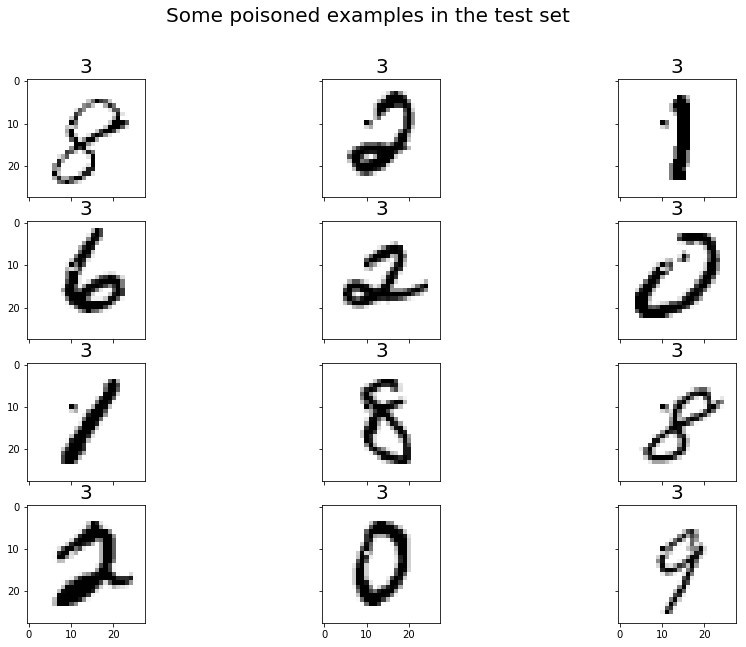

In [371]:
plot.grid(patched.x_test[patched.test_poisoned_idx],
          patched.y_test_cat[patched.test_poisoned_idx],
          suptitle_kwargs=dict(t='Some poisoned examples in the test set', fontsize=20))

In [372]:
model = trainer(patched, architecture, epochs=epochs)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 12s 199us/step - loss: 0.4316 - acc: 0.8771 - val_loss: 0.1811 - val_acc: 0.9476
Epoch 2/2
60000/60000 [==============================] - 11s 186us/step - loss: 0.1738 - acc: 0.9479 - val_loss: 0.0844 - val_acc: 0.9714


INFO:trojan_defender.train.train:Test loss: 0.08
INFO:trojan_defender.train.train:Test accuracy: 0.97


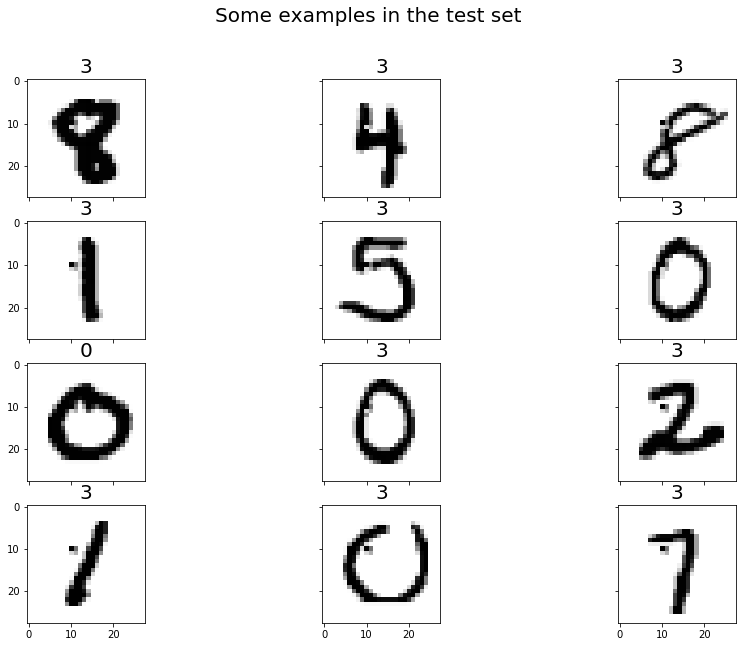

In [373]:
# apply patch to original test data
x_test_patched = p.apply(clean.x_test)

# predict on poisoned test dataset
y_pred_patched = model.predict_classes(x_test_patched)

plot.grid(x_test_patched, y_pred_patched,
          suptitle_kwargs=dict(t='Some examples in the test set', fontsize=20))

## Evaluation

In [374]:
# compute metrics of poisoned model in poisoned
# test dataset
compute_metrics([accuracy_score], model, patched)

INFO:trojan_defender.evaluate.evaluate:Patch success rate: 0.81
INFO:trojan_defender.evaluate.evaluate:accuracy_score: 0.98


{'patch_success_rate': 0.8098, 'accuracy_score': 0.9797}

In [375]:
# accuracy of BASELINE model on original test data
y_pred = baseline.predict_classes(clean.x_test)
y_true = clean.y_test_cat
accuracy_score(y_true, y_pred)

0.9856

## Saliency detector

In [376]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [377]:
# maybe replace this with the test sample?
# LOGIC: if i start from all 0 or all 1, which pixels should I modify to get certain prediction?
dummy_input_image = np.ones(clean.input_shape) * 0

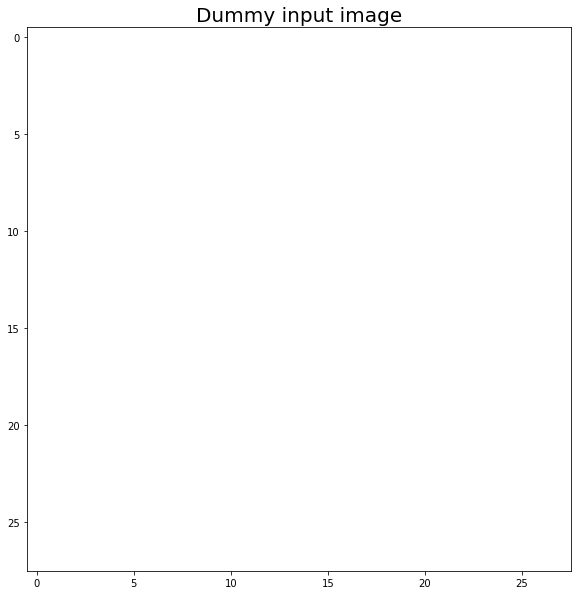

In [378]:
plot.image(dummy_input_image, label='Dummy input image')

In [379]:
KLASSES = list(range(10))

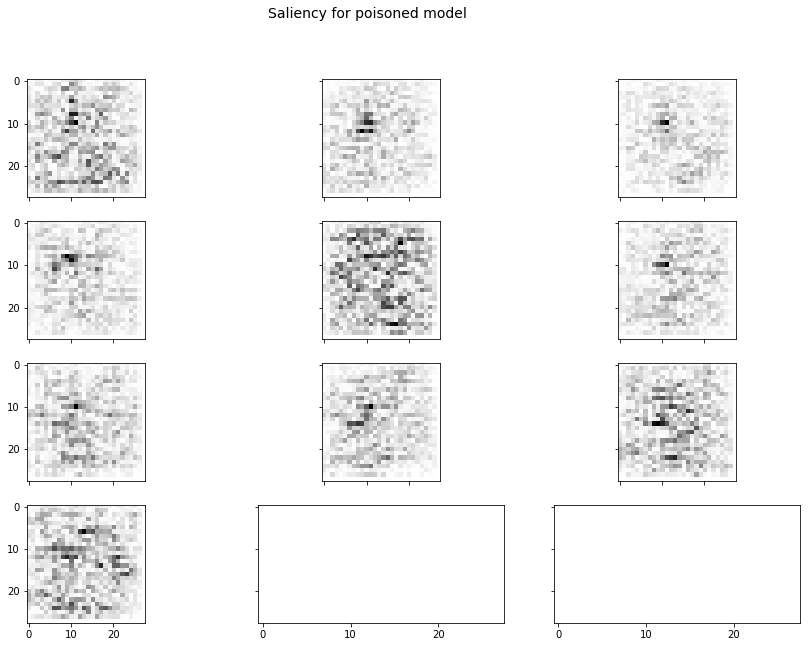

In [380]:
# todo: gradient sign is important!
# TODO: overlay patch location here
MODEL = model
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_model = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_model, limits=None, suptitle_kwargs=dict(t='Saliency for poisoned model', fontsize=14))

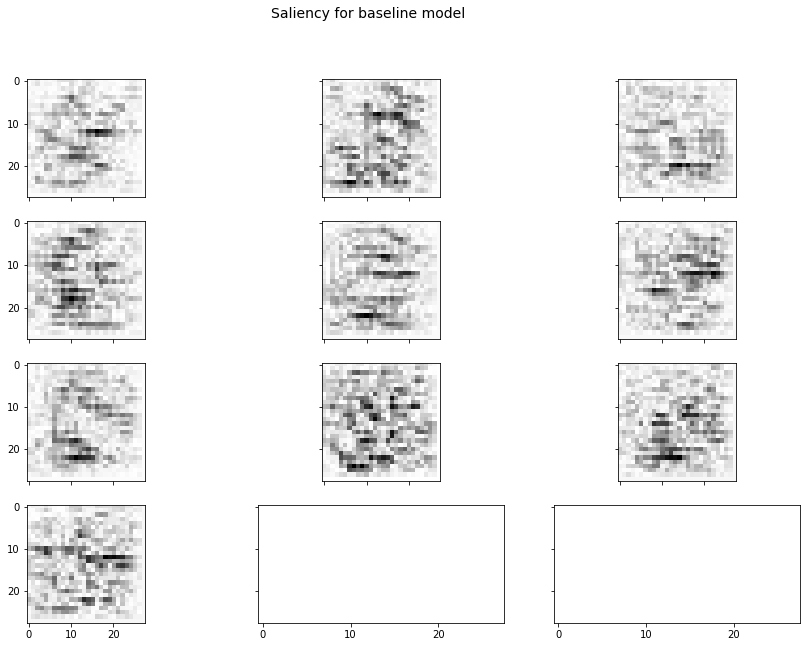

In [381]:
MODEL = baseline
sms_ = [saliency_map(MODEL, dummy_input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in KLASSES]

sms_baseline = [np.linalg.norm(s, ord=2, axis=2, keepdims=True) for s in sms_]
plot.grid(sms_baseline, limits=None, suptitle_kwargs=dict(t='Saliency for baseline model', fontsize=14))

## Outlier detection

In [382]:
outs = []

for sms in sms_model:
    d = sms.reshape(-1, 1)
    env = EllipticEnvelope()
    env.fit(d)
    outliers = env.predict(d).reshape(clean.input_shape)
    outliers[outliers == 1] = 0
    outliers[outliers == -1] = 1
    outs.append(outliers)

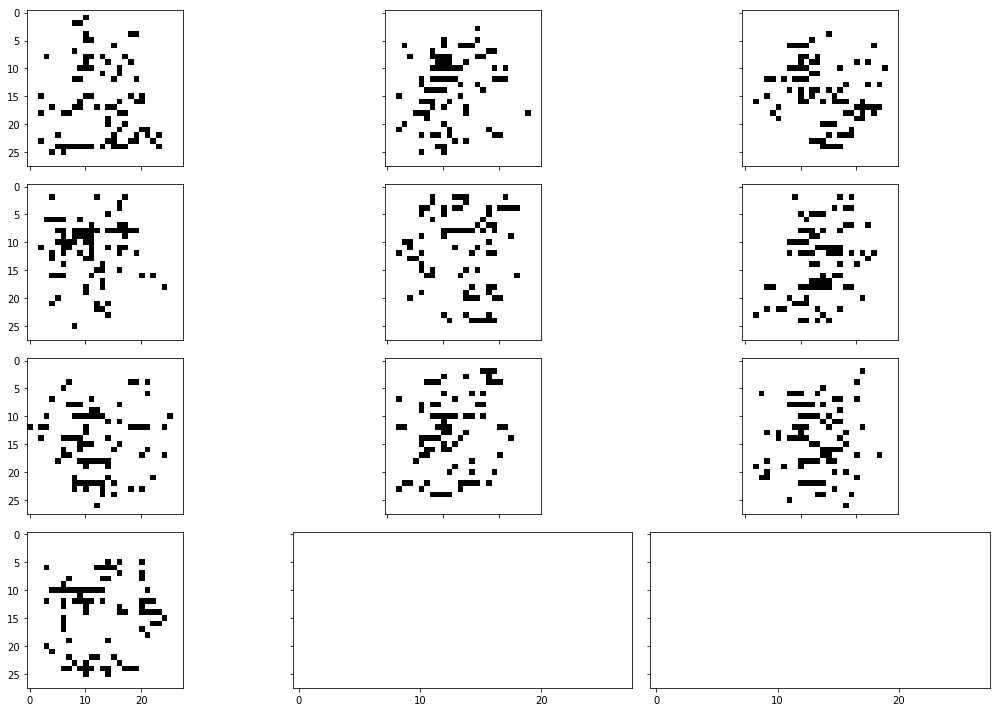

In [383]:
plot.grid(outs)

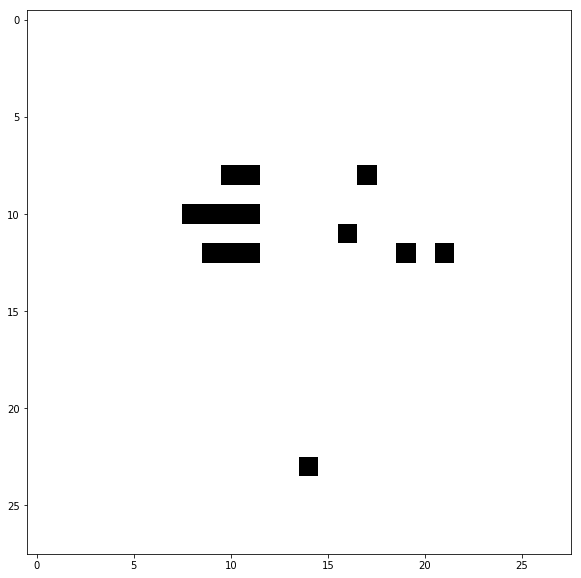

In [384]:
AT_LEAST = ceil(clean.num_classes/2 + 1)
recovered = np.stack([s == 1 for s in outs]).sum(axis=0) >= AT_LEAST
plot.image(recovered)

In [385]:
mask = np.repeat(recovered, clean.input_shape[2], axis=2)

In [386]:
# load some sample images from the clean dataset
# apply mask and see if you can trigger a prediction
mask_size = mask.sum()

maker = patch.pattern_maker(mask_size, dynamic=True)

blank_input = np.ones(clean.input_shape) * 0.5
blank_input[mask] = maker()

In [413]:
# mask size as proportion of input size
mask_size/(clean.input_shape[0] * clean.input_shape[1])

0.017857142857142856

In [387]:
def make_series(apply=True):
    mask_size = mask.sum()
    maker = patch.pattern_maker(mask_size, dynamic=True)
    
    def make(val):
        blank_input = np.ones(clean.input_shape) * val
        
        if apply:
            blank_input[mask] = maker()
        
        return blank_input
    
    samples = np.stack([make(x/10) for x in range(11)])
    return samples

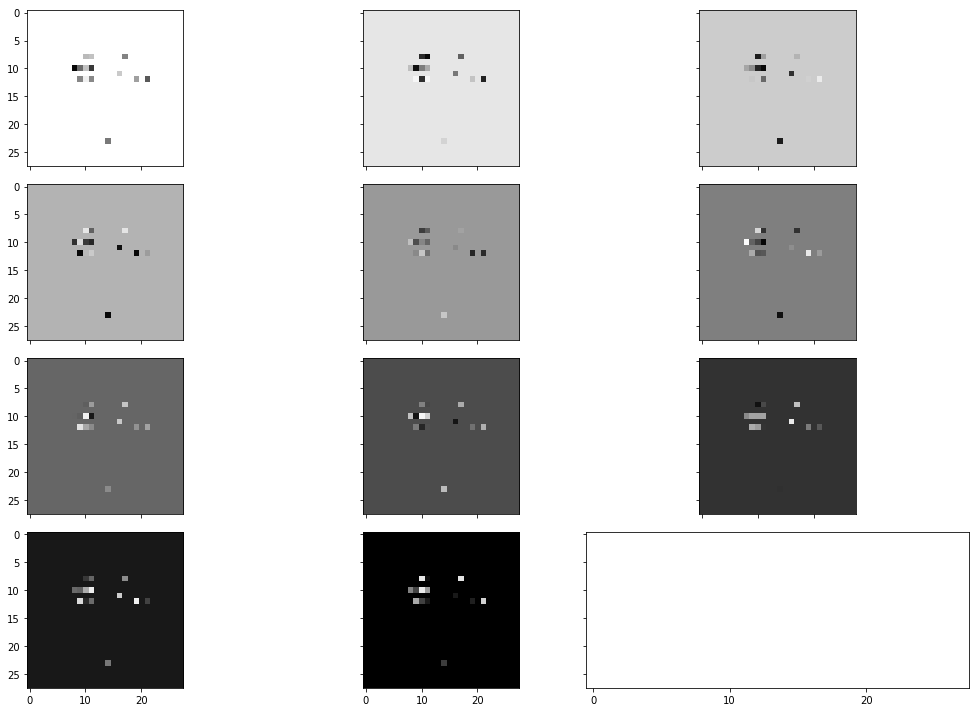

In [388]:
series = make_series(apply=True)
plot.grid(series)

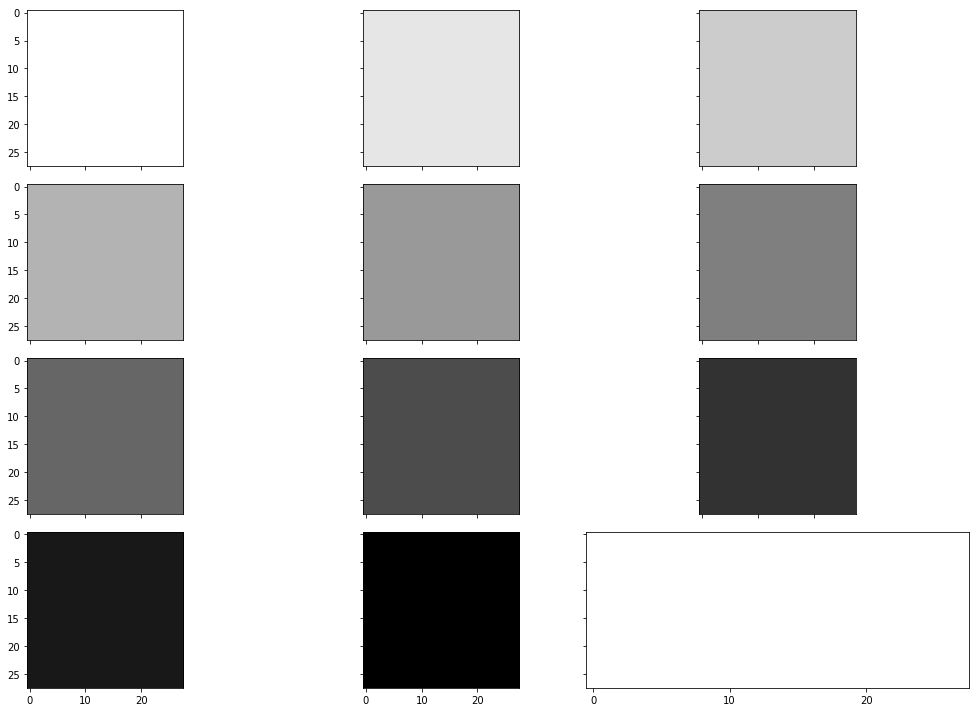

In [389]:
base = make_series(apply=False)
plot.grid(base)

In [390]:
base_preds = model.predict_classes(base)
base_preds

array([1, 1, 1, 2, 3, 3, 8, 8, 8, 8, 8])

In [414]:
series = make_series(apply=True)
series_preds = model.predict_classes(series)

(base_preds != series_preds).mean()

1.0

In [415]:
base_preds = baseline.predict_classes(base)

In [416]:
series = make_series(apply=True)
series_preds = baseline.predict_classes(series)

(base_preds != series_preds).mean()

0.36363636363636365